In [ ]:
%matplotlib widget

# base python modules
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multiprocessing import cpu_count
from skimage.restoration import unwrap_phase

# less standard modules
import pyfftw
import py4DSTEM

# our module
import stemh_tools as st

In [2]:
# paths hard coded from your own device

dataPath = '/Users/andrewducharme/University of Oregon Dropbox/UO-McMorran Lab/ParticipantFiles/Ducharme/Data/STEMH/2306_NCEM_Magnetics/Data/23-06-07/ef_4dstem_edge.dm4'
savePath = '/Users/andrewducharme/University of Oregon Dropbox/UO-McMorran Lab/ParticipantFiles/Ducharme/Data/STEMH/2306_NCEM_Magnetics/Data/23-06-07/'

In [3]:
datacube = py4DSTEM.import_file(dataPath)
data = datacube.data
datacube

DataCube( A 4-dimensional array of shape (140, 200, 1024, 1024) called 'dm_dataset',
          with dimensions:

              Rx = [0.0,0.009856926277279854,0.019713852554559708,...] µm
              Ry = [0.0,0.009856926277279854,0.019713852554559708,...] µm
              Qx = [0.0,1.1456898751190524e-05,2.2913797502381047e-05,...] A^-1
              Qy = [0.0,1.1456898751190524e-05,2.2913797502381047e-05,...] A^-1
)

In [4]:
scan_row_num = datacube.shape[0]  
scan_col_num = datacube.shape[1]  
frame_row_num = datacube.shape[2]
frame_col_num = datacube.shape[3]

print(scan_row_num, scan_col_num)
print(frame_row_num, frame_col_num)

140 200
1024 1024


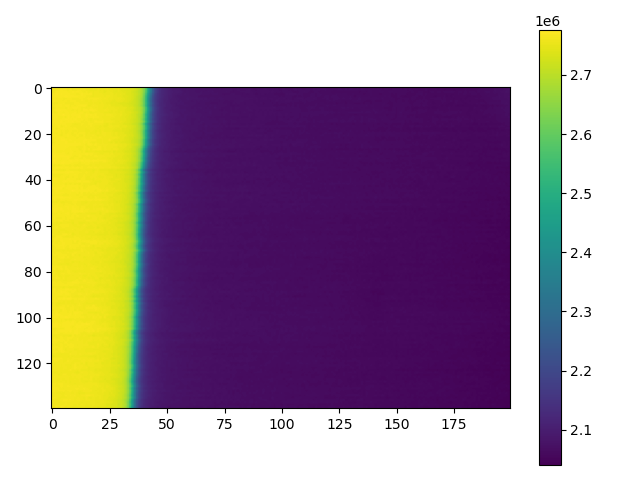

In [ ]:
# create virtual STEM image of data

vSTEM = np.sum(datacube.data, axis=(2,3))

fig, ax = plt.subplots(tight_layout=True)

im = ax.imshow(vSTEM)
plt.colorbar(im)

In [6]:
fig.savefig(savePath + 'vSTEM.png')

Find the location of the peaks in the Fourier transform of an interference pattern. The peak location is essentially constant throughout the scan.

The code tries to find the correct value, but double-check that it isn't picking up the 0th order.

[[190204      3      0]
 [190204   1021      0]
 [151589   1019      0]
 [151589      5      0]
 [ 74621   1017      1]
 [ 55835    829     30]
 [ 47775    827     31]
 [ 40534    824     33]]
[3 0]


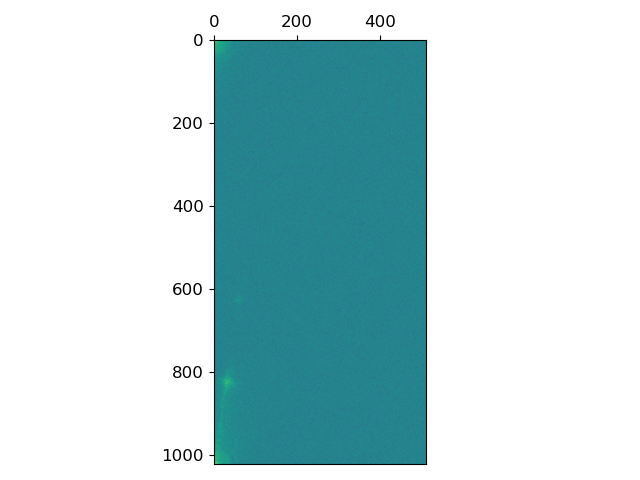

In [ ]:
test_frame = data[100,100]
found_maxima = 8

# find the first order index by computing the real fft to match what we use in the loop
test_rfft = np.fft.rfft2(test_frame)

rfft_peaks = st.fft_find_peaks(test_rfft, found_maxima)  # find n highest magnitude peaks in vac_rfft
print(rfft_peaks)

first_order = rfft_peaks[0, 1:]  # location of first order peak
# selection_size = st.calc_box_size(rfft_peaks) / 4 # eighth the distance between individual fft peaks

print(first_order)

selection_size = 5

# Check the frame isn't obviously garbage.
# The code looks at the raw rFFT, but it's easier for us humans to look at the fftshifted rFFT
# Just remember Fourier peak locations in the fftshifted data are not the locations in the actual analysis
fig, ax = plt.subplots(tight_layout=True)

# ax.imshow(test_frame, cmap='binary')
ax.imshow(np.abs(test_rfft), norm=LogNorm())
# ax.imshow(np.abs(np.fft.fftshift(test_rfft)), norm=LogNorm())

ax.xaxis.tick_top()
ax.tick_params(labelsize = 12)

In [10]:
first_order = (830,30)

In [11]:
# setting up pyfftw numpy interface
pyfftw.config.NUM_THREADS = cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_ESTIMATE'
pyfftw.interfaces.cache.enable()

0
5600
11200
16800
22400
Total time (s): 154.6552300453186
Per frame time (ms): 5.523401073047093
1024 x 1024 time (min): 96.5284300595238


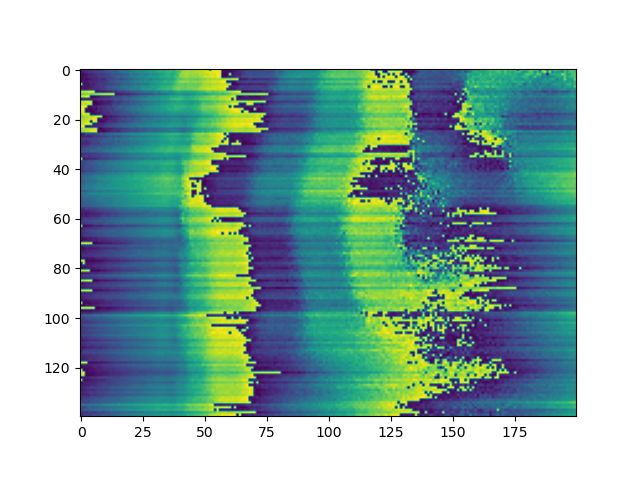

In [ ]:
base = np.empty((frame_row_num, frame_col_num), dtype='float32')
    
# data array made 3D, from (scan_row, scan_col, : ,:) to (scan_row * scan_col, :,:)
num_frames = scan_col_num * scan_row_num
data1D = data.reshape((num_frames, frame_row_num, frame_col_num))

# initialize arrays to store values through loop
peaks = np.zeros(num_frames, dtype=complex)

start = time.time()

# the forward Fourier transform is the vast majority of the work+computation time here
for i, frame in enumerate(data1D):
    if i % (num_frames//5) == 0:
        print(i)

    base[:] = frame

    ft = pyfftw.interfaces.numpy_fft.rfft2(base)  # take Fourier transform of the windowed frame
    # ft = cupy.fft.rfft2(cupy.asarray(frame))

    fourier_space_peak = st.grab_square_box(ft, selection_size, first_order) # select the area around desired peak

    peaks[i] = np.sum(fourier_space_peak)

phaseMap = np.angle(peaks).reshape((scan_row_num, scan_col_num))

end = time.time()

print("Total time (s): " + str(end - start))
print("Per frame time (ms): " + str((end - start) / scan_row_num / scan_col_num * 1000))
print('1024 x 1024 time (min): ' + str((end - start) / scan_row_num / scan_col_num * 1024 * 1024 / 60))

fig, ax = plt.subplots(tight_layout=True)
ax.imshow(phaseMap)

# np.save(savePath + '14Phase_256_ord1', phaseMap)

In [ ]:
fig,ax = plt.subplots(tight_layout=True)
ax.imshow(unwrap_phase(phaseMap))

In [ ]:
# check best locations for plane subtractions for phase map

loc = (100,20)

fig, ax = plt.subplots(tight_layout=True)
ax.xaxis.tick_top()
image = ax.imshow(st.plane_subtract(phaseMap,loc,10,15), cmap='seismic')
plt.colorbar(image)

plt.plot(loc[0],loc[1], 'ro')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [65]:
np.save(savePath + '112Phase_256_ord1', phaseMap)

In [65]:
plt.close('all')